# Nowcasting: 

This notebook intends to walk you through the VIEWS Nowcasting model. The Model uses UCDP Candidate Data to nowcast UCDP GED Final. The notebook is structured as follows:

1.


## 1.0 Packages

In [120]:
import numpy as np
import pandas as pdx
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
import tabula
import xlwings as xw
import seaborn as sns
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.ticker import ScalarFormatter
from nowcast import * #plot_statebased, plot_nonstate, plot_onesided 
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split

from xgboost import XGBRegressor

# VIEWS 3
from viewser.operations import fetch
from viewser import Queryset, Column
import views_runs
from views_partitioning import data_partitioner, legacy
from stepshift import views
from views_runs import storage, ModelMetadata
from views_runs.storage import store, retrieve, fetch_metadata
#from views_forecasts.extensions import *

# Ingester
from ingester3.config import source_db_path
from ingester3.Country import Country
from ingester3.extensions import *
from ingester3.ViewsMonth import ViewsMonth

warnings.filterwarnings('ignore')

import os
home = os.path.expanduser("~")

# 2.0 Gather Data: Query VIEWSER

In [2]:
# 2. UCDP GED Final, ACLED, Topics

qs_nowcasting_cm = (Queryset("nowcasting", "country_month") 
                    
# COUNTRY META-DATA       
.with_column(Column('country_name', from_loa = 'country', from_column = 'name'))
.with_column(Column('iso_ab', from_loa = 'country', from_column = 'isoab'))
.with_column(Column('gleditsch_ward', from_loa = 'country', from_column = 'gwcode'))
.with_column(Column('year', from_loa = 'month', from_column = 'year_id'))
.with_column(Column('month', from_loa = 'month', from_column = 'month'))

# UCDP GED FINAL                    
.with_column(Column('sb_final_best', from_loa = 'country_month', from_column = 'ged_sb_best_sum_nokgi'))
.with_column(Column('ns_final_best', from_loa = 'country_month', from_column = 'ged_ns_best_sum_nokgi'))
.with_column(Column('os_final_best', from_loa = 'country_month', from_column = 'ged_os_best_sum_nokgi'))
.with_column(Column('sb_ged_count_events', from_loa = 'country_month', from_column = 'ged_sb_best_count_nokgi'))
.with_column(Column('ns_ged_count_events', from_loa = 'country_month', from_column = 'ged_ns_best_count_nokgi'))
.with_column(Column('os_ged_count_events', from_loa = 'country_month', from_column = 'ged_os_best_count_nokgi'))  
                    
# Logged VERSIONS
.with_column(Column("sb_final_best_ln", from_loa = "country_month", from_column = "ged_sb_best_sum_nokgi")
                 .transform.ops.ln()
                 .transform.missing.replace_na()) 
                    
.with_column(Column("ns_final_best_ln", from_loa = "country_month", from_column = "ged_ns_best_sum_nokgi")
                 .transform.ops.ln()
                 .transform.missing.replace_na()) 
                    
.with_column(Column("os_final_best_ln", from_loa = "country_month", from_column = "ged_os_best_sum_nokgi")
                 .transform.ops.ln()
                 .transform.missing.replace_na()) 

# LAGGED VERSIONS
.with_column(Column("sb_final_best_ln_1", from_loa = "country_month", from_column = "ged_sb_best_sum_nokgi")
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(1)
                 .transform.missing.replace_na()) 

.with_column(Column("sb_final_best_ln_2", from_loa = "country_month", from_column = "ged_sb_best_sum_nokgi")
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(2)
                 .transform.missing.replace_na())
                    
.with_column(Column("sb_final_best_ln_3", from_loa = "country_month", from_column = "ged_sb_best_sum_nokgi")
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(3)
                 .transform.missing.replace_na())
                    
.with_column(Column("sb_final_best_ln_4", from_loa = "country_month", from_column = "ged_sb_best_sum_nokgi")
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(4)
                 .transform.missing.replace_na())
                    
.with_column(Column("sb_final_best_ln_5", from_loa = "country_month", from_column = "ged_sb_best_sum_nokgi")
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(5)
                 .transform.missing.replace_na())

.with_column(Column("sb_final_best_ln_6", from_loa = "country_month", from_column = "ged_sb_best_sum_nokgi")
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(6)
                 .transform.missing.replace_na())

.with_column(Column("sb_final_best_ln_7", from_loa = "country_month", from_column = "ged_sb_best_sum_nokgi")
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(7)
                 .transform.missing.replace_na())

.with_column(Column("sb_final_best_ln_8", from_loa = "country_month", from_column = "ged_sb_best_sum_nokgi")
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(8)
                 .transform.missing.replace_na())

.with_column(Column("sb_final_best_ln_9", from_loa = "country_month", from_column = "ged_sb_best_sum_nokgi")
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(9)
                 .transform.missing.replace_na())

.with_column(Column("sb_final_best_ln_12", from_loa = "country_month", from_column = "ged_sb_best_sum_nokgi")
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(12)
                 .transform.missing.replace_na()) 
                    
.with_column(Column("sb_final_best_ln_24", from_loa = "country_month", from_column = "ged_sb_best_sum_nokgi")
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(24)
                 .transform.missing.replace_na())  
                    
# ACLED DATA                    
.with_column(Column('acled_sb_fat', from_loa = 'country_month', from_column = 'acled_sb_fat'))
                    
.with_column(Column('acled_sb_fat_ln', from_loa = 'country_month', from_column = 'acled_sb_fat')
                 .transform.ops.ln()
                 .transform.missing.fill())
                    
.with_column(Column('acled_ns_fat_ln', from_loa = 'country_month', from_column = 'acled_ns_fat')
                 .transform.ops.ln()
                 .transform.missing.fill())
                    
.with_column(Column('acled_os_fat_ln', from_loa = 'country_month', from_column = 'acled_os_fat')
                 .transform.ops.ln()
                 .transform.missing.fill())
                    
.with_column(Column('acled_sb_fat_ln_1', from_loa = 'country_month', from_column = 'acled_sb_fat')
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(1)
                 .transform.missing.replace_na()) 
                    
.with_column(Column('acled_sb_fat_ln_2', from_loa = 'country_month', from_column = 'acled_sb_fat')
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(2)
                 .transform.missing.replace_na()) 
                    
.with_column(Column('acled_sb_fat_ln_3', from_loa = 'country_month', from_column = 'acled_sb_fat')
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(3)
                 .transform.missing.replace_na()) 

.with_column(Column('acled_sb_fat_ln_12', from_loa = 'country_month', from_column = 'acled_sb_fat')
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(12)
                 .transform.missing.replace_na()) 

.with_column(Column('acled_sb_fat_ln_24', from_loa = 'country_month', from_column = 'acled_sb_fat')
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(24)
                 .transform.missing.replace_na()) 
                                       
.with_column(Column('acled_sb_count', from_loa = 'country_month', from_column = 'acled_sb_count'))
.with_column(Column('acled_ns_fat', from_loa = 'country_month', from_column = 'acled_ns_fat'))
.with_column(Column('acled_ns_count', from_loa = 'country_month', from_column = 'acled_ns_count'))
.with_column(Column('acled_os_fat', from_loa = 'country_month', from_column = 'acled_os_fat'))
.with_column(Column('acled_os_count', from_loa = 'country_month', from_column = 'acled_os_count'))
.with_column(Column('acled_pr_count', from_loa = 'country_month', from_column = 'acled_pr_count'))

.with_column(Column("ln_acled_sb_reb", from_loa="country_month", from_column="acled_bat_reb_fat")
                                    .transform.ops.ln()
                                    .transform.missing.fill()
                                    )

.with_column(Column("ln_acled_sb_gov", from_loa="country_month", from_column="acled_bat_gov_fat")
                                    .transform.ops.ln()
                                    .transform.missing.fill()
                                    )

# TOPICS DATA                                    
.with_column(Column('topic_conflict_1', from_loa = 'country_month', from_column = 'topic_ste_theta6')
                 .transform.missing.fill()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(1)
                 .transform.missing.fill())

.with_column(Column('topic_judiciary_1', from_loa = 'country_month', from_column = 'topic_ste_theta5')
                 .transform.missing.fill()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(1)
                 .transform.missing.fill())

.with_column(Column('topic_diplomacy_1', from_loa = 'country_month', from_column = 'topic_ste_theta2')
                 .transform.missing.fill()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(1)
                 .transform.missing.fill())
                    
# VDEM Data
.with_column(Column("vdem_v2x_delibdem", from_loa="country_year", from_column="vdem_v2x_delibdem")
                 .transform.missing.fill()
                 .transform.temporal.tlag(12)
                 .transform.missing.fill()
                 .transform.missing.replace_na())

.with_column(Column("vdem_v2x_clphy", from_loa="country_year", from_column="vdem_v2x_clphy")
                 .transform.missing.fill()
                 .transform.temporal.tlag(12)
                 .transform.missing.fill()
                 .transform.missing.replace_na())

.with_column(Column("vdem_v2x_rule", from_loa="country_year", from_column="vdem_v2x_rule")
                 .transform.missing.fill()
                 .transform.temporal.tlag(12)
                 .transform.missing.fill()
                 .transform.missing.replace_na())
                    
.with_column(Column("vdem_v2x_freexp", from_loa="country_year", from_column="vdem_v2x_freexp")
                 .transform.missing.fill()
                 .transform.temporal.tlag(12)
                 .transform.missing.fill()
                 .transform.missing.replace_na())

# Topic Models

.with_column(Column('topic_tokens_t1', from_loa='country_month', from_column='topic_tokens')
            .transform.missing.fill()
            .transform.missing.replace_na()
            .transform.temporal.tlag(1)
            .transform.missing.fill()
            .transform.missing.replace_na()
            )

.with_column(Column('topic_tokens_t2', from_loa='country_month', from_column='topic_tokens')
            .transform.missing.fill()
            .transform.missing.replace_na()
            .transform.temporal.tlag(2)
            .transform.missing.fill()
            .transform.missing.replace_na()
            )

.with_column(Column('topic_ste_theta4_stock_t1', from_loa='country_month', from_column='topic_ste_theta4_stock')
            .transform.missing.fill()
            .transform.missing.replace_na()
            .transform.temporal.tlag(1)
            .transform.missing.fill()
            .transform.missing.replace_na()
            )

.with_column(Column('topic_ste_theta4_stock_t2', from_loa='country_month', from_column='topic_ste_theta4_stock')
            .transform.missing.fill()
            .transform.missing.replace_na()
            .transform.temporal.tlag(2)
            .transform.missing.fill()
            .transform.missing.replace_na()
            )

.with_column(Column('topic_ste_theta4_stock_t13', from_loa='country_month', from_column='topic_ste_theta4_stock')
            .transform.missing.fill()
            .transform.missing.replace_na()
            .transform.temporal.tlag(13)
            .transform.missing.fill()
            .transform.missing.replace_na()
            )

.with_column(Column('topic_ste_theta2_stock_t1', from_loa='country_month', from_column='topic_ste_theta5_stock')
            .transform.missing.fill()
            .transform.missing.replace_na()
            .transform.temporal.tlag(1)
            .transform.missing.fill()
            .transform.missing.replace_na()
            )

.with_column(Column('topic_ste_theta2_stock_t2', from_loa='country_month', from_column='topic_ste_theta5_stock')
            .transform.missing.fill()
            .transform.missing.replace_na()
            .transform.temporal.tlag(2)
            .transform.missing.fill()
            .transform.missing.replace_na()
            )

.with_column(Column('topic_ste_theta2_stock_t13', from_loa='country_month', from_column='topic_ste_theta5_stock')
            .transform.missing.fill()
            .transform.missing.replace_na()
            .transform.temporal.tlag(13)
            .transform.missing.fill()
            .transform.missing.replace_na()
            )

# Nowcasting Data
# UCDP GED FINAL                    
.with_column(Column('sb_candidate_best', from_loa = 'country_month', from_column = 'candidate_sb_best'))
.with_column(Column('ns_candidate_best', from_loa = 'country_month', from_column = 'candidate_ns_best'))
.with_column(Column('os_candidate_best', from_loa = 'country_month', from_column = 'candidate_os_best'))

.with_column(Column('sb_candidate_high', from_loa = 'country_month', from_column = 'candidate_sb_high'))
.with_column(Column('ns_candidate_high', from_loa = 'country_month', from_column = 'candidate_ns_high'))
.with_column(Column('os_candidate_high', from_loa = 'country_month', from_column = 'candidate_os_high'))

.with_column(Column('sb_candidate_count_events', from_loa = 'country_month', from_column = 'candidate_sb_count'))
.with_column(Column('ns_candidate_count_events', from_loa = 'country_month', from_column = 'candidate_ns_count'))
.with_column(Column('os_candidate_count_events', from_loa = 'country_month', from_column = 'candidate_os_count'))

.with_column(Column('sb_candidate_high_count', from_loa = 'country_month', from_column = 'candidate_sb_high_count'))
.with_column(Column('ns_candidate_high_count', from_loa = 'country_month', from_column = 'candidate_ns_high_count'))
.with_column(Column('os_candidate_high_count', from_loa = 'country_month', from_column = 'candidate_os_high_count'))

# Logged VERSIONS
.with_column(Column('sb_candidate_best_ln', from_loa='country_month', from_column='candidate_sb_best')
             .transform.ops.ln()
             .transform.missing.replace_na())

.with_column(Column('ns_candidate_best_ln', from_loa='country_month', from_column='candidate_ns_best')
             .transform.ops.ln()
             .transform.missing.replace_na())

.with_column(Column('os_candidate_best_ln', from_loa='country_month', from_column='candidate_os_best')
             .transform.ops.ln()
             .transform.missing.replace_na())

.with_column(Column('sb_candidate_high_ln', from_loa='country_month', from_column='candidate_sb_high')
             .transform.ops.ln()
             .transform.missing.replace_na())

.with_column(Column('ns_candidate_high_ln', from_loa='country_month', from_column='candidate_ns_high')
             .transform.ops.ln()
             .transform.missing.replace_na())

.with_column(Column('os_candidate_high_ln', from_loa='country_month', from_column='candidate_os_high')
             .transform.ops.ln()
             .transform.missing.replace_na())

# Lagged versions 
.with_column(Column("sb_candidate_best_ln_1", from_loa = "country_month", from_column = "candidate_sb_best")
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(1)
                 .transform.missing.replace_na()) 

.with_column(Column("sb_candidate_best_ln_2", from_loa = "country_month", from_column = "candidate_sb_best")
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(2)
                 .transform.missing.replace_na())
                    
.with_column(Column("sb_candidate_best_ln_3", from_loa = "country_month", from_column = "candidate_sb_best")
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(3)
                 .transform.missing.replace_na())
                    
.with_column(Column("sb_candidate_best_ln_4", from_loa = "country_month", from_column = "candidate_sb_best")
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(4)
                 .transform.missing.replace_na())
                    
.with_column(Column("sb_candidate_best_ln_5", from_loa = "country_month", from_column = "candidate_sb_best")
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(5)
                 .transform.missing.replace_na())

.with_column(Column("sb_candidate_best_ln_6", from_loa = "country_month", from_column = "candidate_sb_best")
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(6)
                 .transform.missing.replace_na())

## High
.with_column(Column("sb_candidate_high_ln_1", from_loa = "country_month", from_column = "candidate_sb_high")
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(1)
                 .transform.missing.replace_na()) 

.with_column(Column("sb_candidate_high_ln_2", from_loa = "country_month", from_column = "candidate_sb_high")
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(2)
                 .transform.missing.replace_na())
                    
.with_column(Column("sb_candidate_high_ln_3", from_loa = "country_month", from_column = "candidate_sb_high")
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(3)
                 .transform.missing.replace_na())
                    
.with_column(Column("sb_candidate_high_ln_4", from_loa = "country_month", from_column = "candidate_sb_high")
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(4)
                 .transform.missing.replace_na())
                    
.with_column(Column("sb_candidate_high_ln_5", from_loa = "country_month", from_column = "candidate_sb_high")
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(5)
                 .transform.missing.replace_na())

.with_column(Column("sb_candidate_high_ln_6", from_loa = "country_month", from_column = "candidate_sb_high")
                 .transform.ops.ln()
                 .transform.missing.replace_na()
                 .transform.temporal.tlag(6)
                 .transform.missing.replace_na())
 )
                     
qs_nowcasting_cm = qs_nowcasting_cm.publish().fetch()

100%|██████████| 9.31M/9.31M [00:00<00:00, 46.9MB/s]


Queryset nowcasting read successfully 


### **Subset the data to only include Nowcasting Years**

In [3]:
df = qs_nowcasting_cm.copy()

df.reset_index(inplace = True)
df = df.loc[df['year'] <= 2023]
df = df.loc[df['year'] >= 2018]
df = df.rename(columns={'month_id': 'month_id', 'country_id': 'c_id'})
df = df.set_index(['month_id', 'c_id'])
one_hot = pd.get_dummies(df['iso_ab'])
df = df.join(one_hot)

df = df.drop(['country_name', 'gleditsch_ward'], axis=1)

### **Subset the data to only include the countries by the year they enter the UCDP Candidate Data**

In [4]:
# Define country lists

african_iso3_codes = {
    "AGO", "BDI", "BEN", "BFA", "BWA", "CAF", "CIV", "CMR", "COG", "COM", "CPV",
    "ERI", "ETH", "GAB", "GHA", "GIN", "GMB", "GNB", "GNQ", "KEN", "LBR", "LSO",
    "MDG", "MLI", "MOZ", "MRT", "MUS", "MWI", "NAM", "NER", "NGA", "RWA", "SDN",
    "SEN", "SLE", "SOM", "SSD", "STP", "SWZ", "SYC", "TCD", "TGO", "TZA", "UGA",
    "ZAF", "ZAR", "ZMB", "ZWE"
}

middle_east_iso3_codes = {
    "AFG", "ARE", "BHR", "DJI", "DZA", "EGY", "IRN", "IRQ", "ISR", "JOR", "KWT", "LBN",
    "LBY", "MAR", "MLT", "OMN", "QAT", "SAU", "SYR", "TUN", "TUR", "YEM"
}

new_countries_iso3 = {
    "ALB", "AND", "ARM", "AUT", "AZE", "BEL", "BGR", "BIH", "BLR", "CHE", "CYP", "CZE", "DEU",
    "DNK", "ESP", "EST", "FIN", "FRA", "FRO", "GBR", "GEO", "GRC", "GRL", "HRV", "HUN", "IRL",
    "ISL", "ITA", "KAZ", "KGZ", "KSV", "LIE", "LTU", "LUX", "LVA", "MCO", "MDA", "MKD", "MNT",
    "NLD", "NOR", "POL", "PRT", "ROM", "RUS", "SER", "SMR", "SVK", "SVN", "SWE", "TJK", "TKM",
    "UKR", "UZB", "BGD", "BTN", "IND", "LKA", "MDV", "NPL", "PAK", "ASM", "AUS",
    "BRN", "CHN", "FJI", "FSM", "GUM", "HKG", "IDN", "JPN", "KHM", "KIR", "KOR", "LAO", "MAC",
    "MHL", "MMR", "MNG", "MNP", "MYS", "NCL", "NZL", "PHL", "PLW", "PNG", "PRK", "PYF", "SGP",
    "SLB", "THA", "TMP", "TON", "TUV", "VNM", "VUT", "WSM"
}


# Start by copying the master DataFrame
master_new = df.copy()

# Define your inclusion mask — where data should be kept (i.e., values kept for 'sb_candidate_best_ln')
keep_mask = (
    # All years except 2018-2019
    (~master_new["year"].isin([2018, 2019])) |

    # African countries in 2018-2019
    (master_new["iso_ab"].isin(african_iso3_codes)) |

    # African countries for Jan-Mar 2020
    ((master_new["year"] == 2020) & (master_new["month"].isin([1, 2, 3])) & master_new["iso_ab"].isin(african_iso3_codes)) |

    # African + Middle East countries for Apr-Jul 2020
    ((master_new["year"] == 2020) & (master_new["month"].between(4, 7)) & 
     (master_new["iso_ab"].isin(african_iso3_codes) | master_new["iso_ab"].isin(middle_east_iso3_codes))) |

    # African + Middle East + new countries from Aug 2020 onward
    ((master_new["year"] > 2020) |
     ((master_new["year"] == 2020) & (master_new["month"] >= 8) &
      (master_new["iso_ab"].isin(african_iso3_codes) |
       master_new["iso_ab"].isin(middle_east_iso3_codes) |
       master_new["iso_ab"].isin(new_countries_iso3))))
)

# Explicitly exclude Middle East countries before April 2020
keep_mask &= ~((master_new["year"] == 2020) & (master_new["month"] < 4) & master_new["iso_ab"].isin(middle_east_iso3_codes))

# Explicitly exclude new countries before August 2020
keep_mask &= ~((master_new["year"] == 2020) & (master_new["month"] < 8) & master_new["iso_ab"].isin(new_countries_iso3))

# Now, set sb_candidate_best_ln to NaN for rows NOT in the keep_mask
master_new.loc[~keep_mask, "sb_candidate_best_ln"] = np.nan

# drop columns with nan on 'sb_candidate_best_ln'
master_new = master_new.dropna(subset=['sb_candidate_best_ln'])

df = master_new.copy()


### **Reducing the Feature Sets** and **Creating training and testsets**

In [5]:
countries = [
    'AFG', 'AGO', 'ALB', 'ARE', 'ARG', 'ARM', 'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 
    'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BOL', 
    'BRA', 'BRB', 'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 
    'COD', 'COG', 'COL', 'COM', 'CRI', 'CUB', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA', 
    'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 
    'FRA', 'GAB', 'GBR', 'GEO', 'GHA', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD', 
    'GTM', 'GUY', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 
    'ISL', 'ISR', 'ITA', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KOR', 
    'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LKA', 'LTU', 'LUX', 'LVA', 'MAR', 'MDA', 
    'MDG', 'MDV', 'MEX', 'MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MNG', 'MOZ', 'MRT', 
    'MUS', 'MWI', 'MYS', 'NAM', 'NER', 'NGA', 'NIC', 'NLD', 'NOR', 'NPL', 'NZL', 
    'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'PNG', 'POL', 'PRK', 'PRT', 'PRY', 'QAT', 
    'ROU', 'RUS', 'RWA', 'SAU', 'SDN', 'SEN', 'SGP', 'SLE', 'SLV', 'SOM', 'SRB', 
    'SSD', 'SVK', 'SVN', 'SWE', 'SWZ', 'SYC', 'SYR', 'TCD', 'TGO', 'THA', 'TJK', 
    'TKM', 'TLS', 'TTO', 'TUN', 'TUR', 'TWN', 'TZA', 'UGA', 'UKR', 'URY', 'USA', 
    'UZB', 'VEN', 'VNM', 'YEM', 'ZAF', 'ZMB', 'ZWE'] 


short_features = ['sb_final_best_ln', 'sb_candidate_best_ln', 'ns_candidate_best_ln', 'os_candidate_best_ln',
       'sb_candidate_high_ln', 'ns_candidate_high_ln', 'os_candidate_high_ln',
       'sb_candidate_count_events', 'ns_candidate_count_events',
       'os_candidate_count_events', 'sb_candidate_high_count',
       'ns_candidate_high_count', 'os_candidate_high_count',
       'acled_sb_fat_ln', 'acled_ns_fat_ln', 'acled_os_fat_ln',
       'acled_sb_count', 'acled_ns_count', 'acled_os_count',
       'sb_final_best_ln_12', 'sb_final_best_ln_24', 'acled_sb_fat_ln_1',
       'acled_sb_fat_ln_2', 'acled_sb_fat_ln_3', 'acled_sb_fat_ln_12',
       'acled_sb_fat_ln_24', 'topic_conflict_1', 'topic_judiciary_1',
       'topic_diplomacy_1', 'vdem_v2x_delibdem', 'vdem_v2x_clphy',
       'vdem_v2x_rule', 'vdem_v2x_freexp', 'sb_candidate_best_ln_1',
       'sb_candidate_best_ln_2', 'sb_candidate_best_ln_3',
       'sb_candidate_best_ln_4', 'sb_candidate_best_ln_5',
       'sb_candidate_best_ln_6', 'sb_candidate_high_ln_1',
       'sb_candidate_high_ln_2', 'sb_candidate_high_ln_3',
       'sb_candidate_high_ln_4', 'sb_candidate_high_ln_5',
       'sb_candidate_high_ln_6', 'acled_pr_count', 
       'topic_tokens_t1', 'topic_tokens_t2', 'topic_ste_theta4_stock_t1', 'topic_ste_theta4_stock_t2',
       'topic_ste_theta4_stock_t13', 'topic_ste_theta2_stock_t1', 'topic_ste_theta2_stock_t2', 'topic_ste_theta2_stock_t13',
       'year', 'month'
       ]

short_list = short_features + countries

# Create a new DataFrame with only the selected columns
df2 = df[short_list]


In [6]:
df_train = df2[df2['year'].between(2018, 2022)]
df_test = df2[df2['year'] == 2023]

# Define X and y for train and test
X_train = df_train.drop(columns=['sb_final_best_ln'])
y_train = df_train['sb_final_best_ln']

X_test = df_test.drop(columns=['sb_final_best_ln'])
y_test = df_test['sb_final_best_ln']

# 3.0 Visulize Data

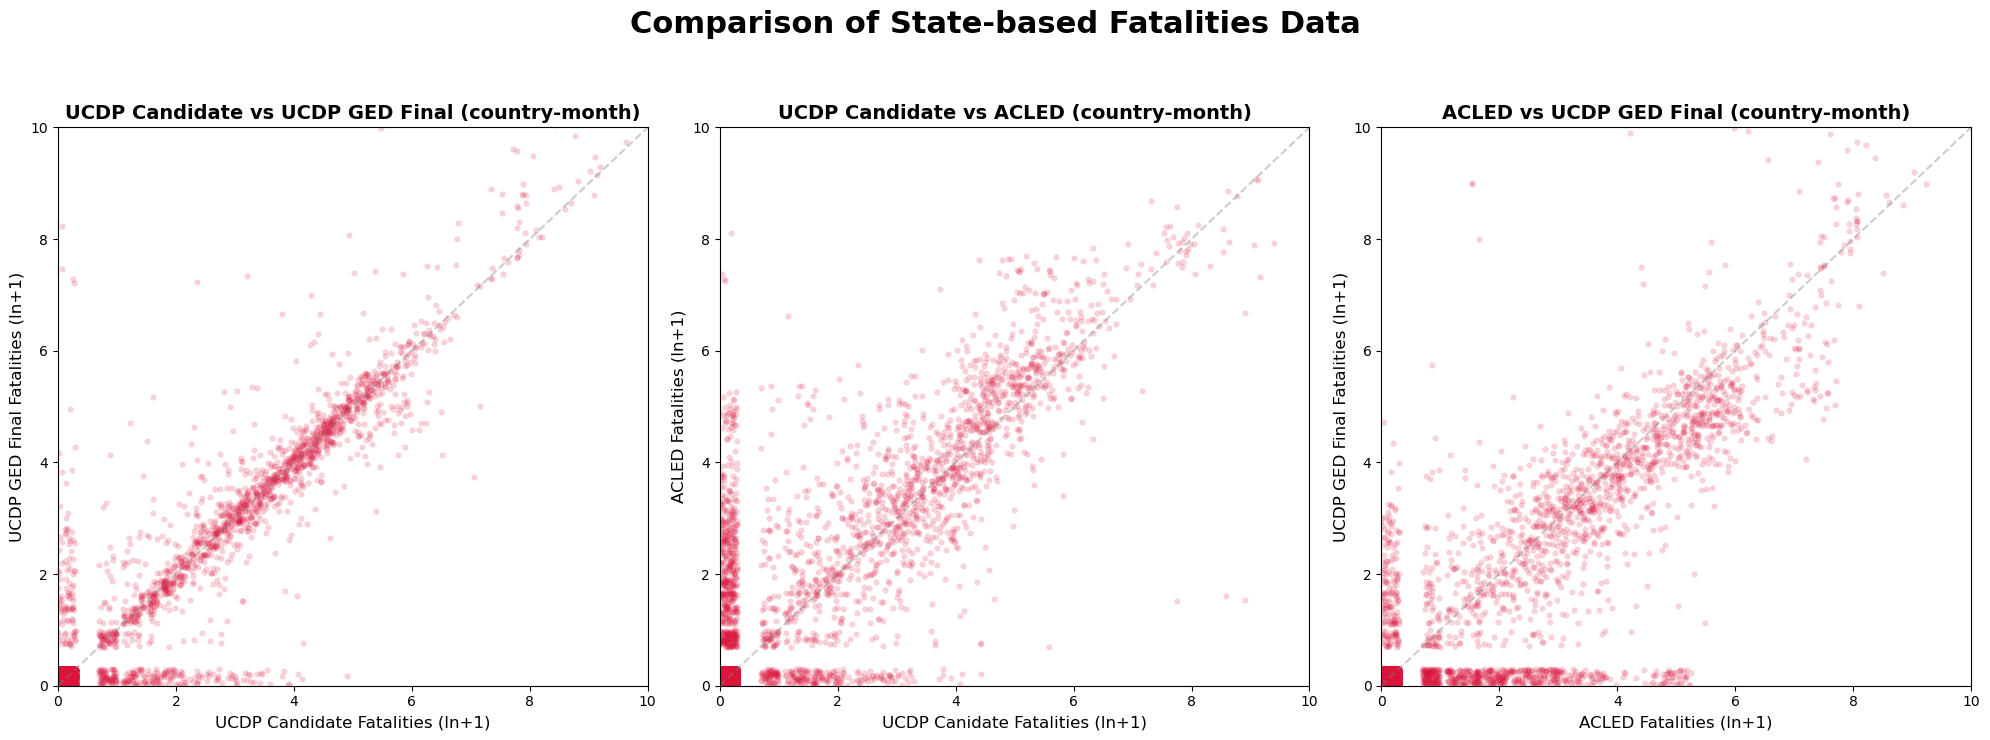

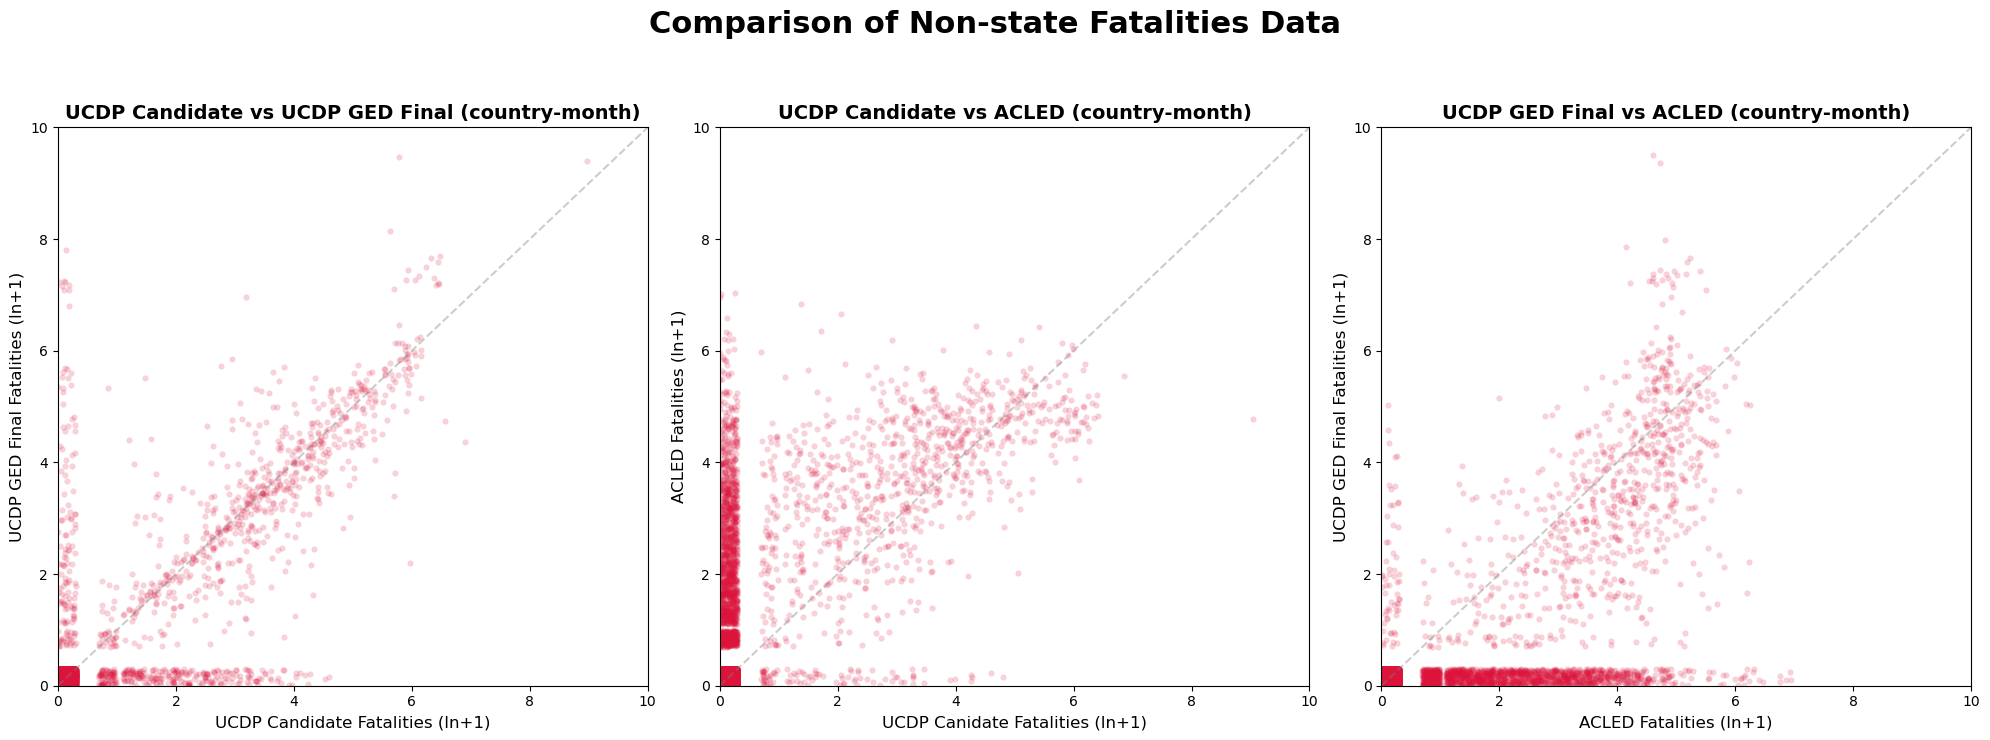

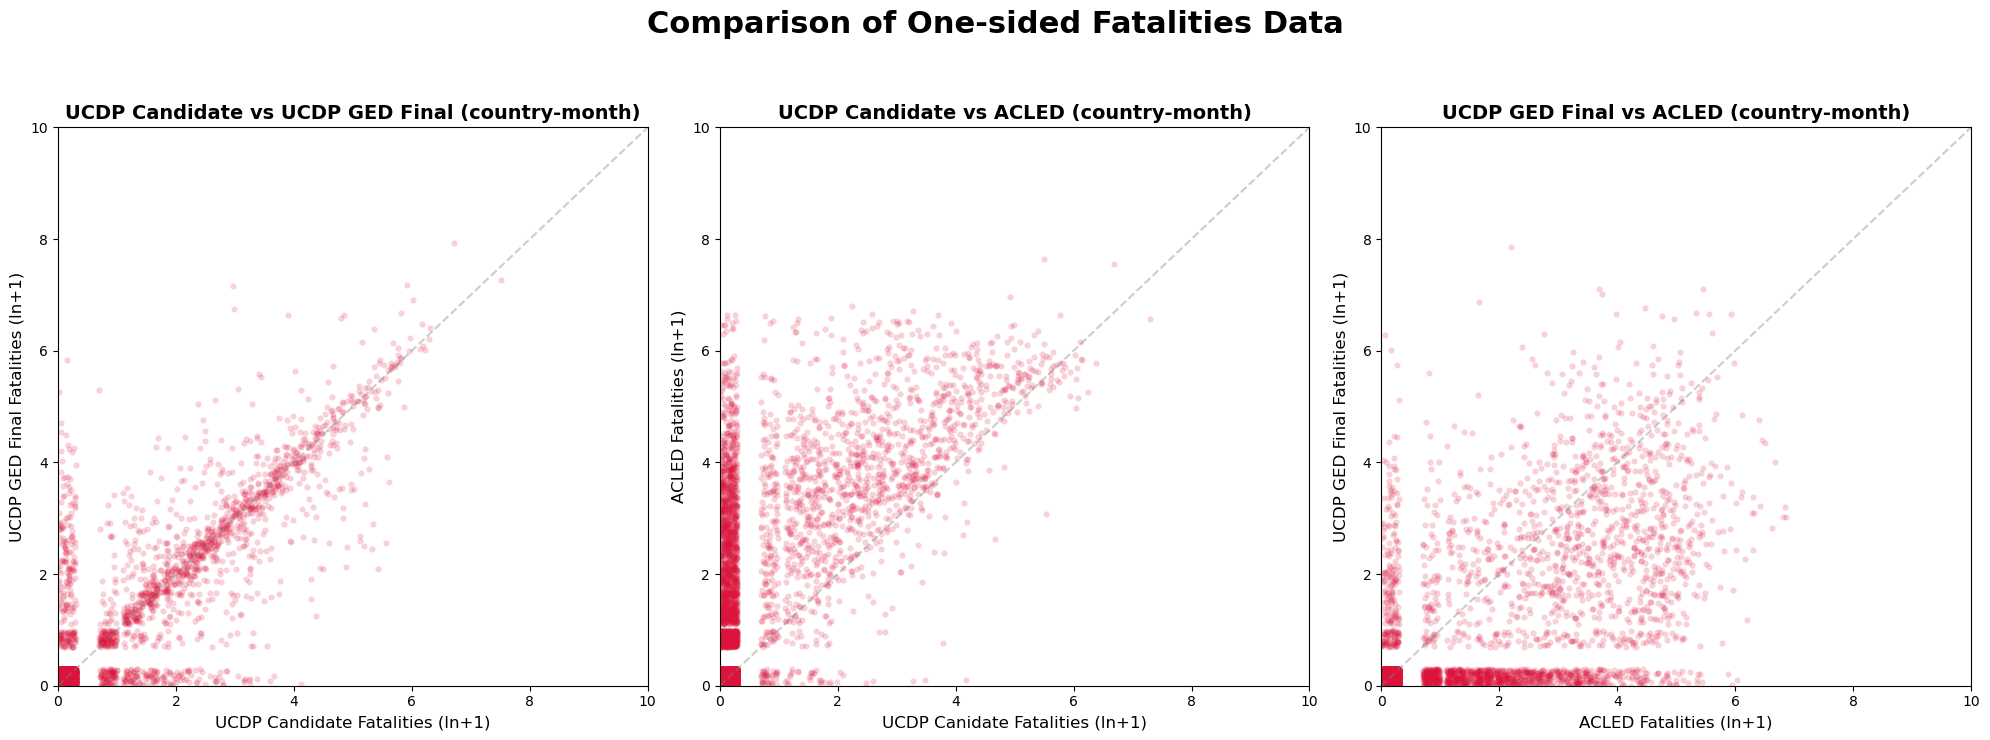

In [7]:
plot_statebased(df)
plot_nonstate(df)
plot_onesided(df)

### **Training and testsets**

Training Examples: 7385
Training Examples: 7385
Test Examples: 2292
Test Examples: 2292


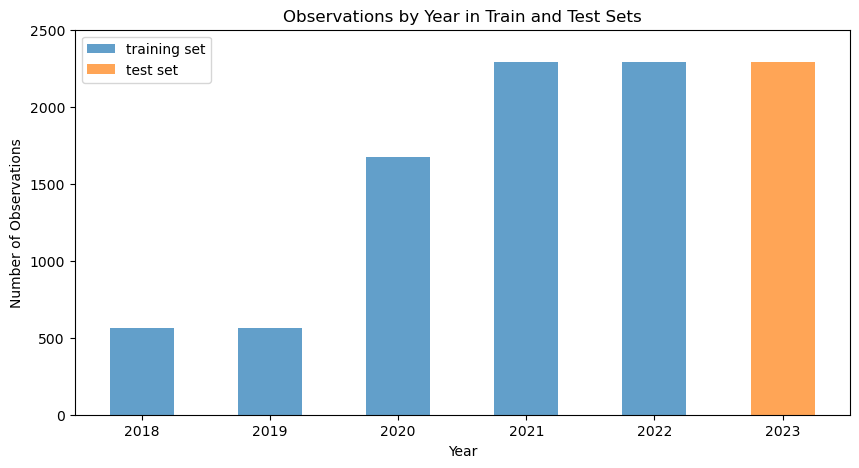

In [8]:
year_min = min(X_train["year"].min(), X_test["year"].min())
year_max = max(X_train["year"].max(), X_test["year"].max())

# Create bin edges from the minimum year to the maximum year
bin_edges = np.arange(year_min - 0.5, year_max + 1.5, 1)

# Plot histograms 
X_train["year"].hist(bins=bin_edges, figsize=(10, 5), label="training set", alpha=0.7, rwidth=0.5)
X_test["year"].hist(bins=bin_edges, figsize=(10, 5), label="test set", alpha=0.7, rwidth=0.5)


plt.title("Observations by Year in Train and Test Sets")
plt.ylim(0, 2500)
plt.xlabel("Year")
plt.ylabel("Number of Observations")
plt.grid(False)
plt.legend()

print("Training Examples:", len(X_train))
print("Training Examples:", len(y_train))

print("Test Examples:", len(X_test))
print("Test Examples:", len(y_test))

# 4.0 Hurdle Models

The best performing models appear to be the hurdle models. The following section introduces a series of hurdle models. 

In [9]:
countries = [
    'AFG', 'AGO', 'ALB', 'ARE', 'ARG', 'ARM', 'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 
    'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLR', 'BLZ', 'BOL', 
    'BRA', 'BRB', 'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 
    'COD', 'COG', 'COL', 'COM', 'CRI', 'CUB', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA', 
    'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 
    'FRA', 'GAB', 'GBR', 'GEO', 'GHA', 'GIN', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD', 
    'GTM', 'GUY', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 
    'ISL', 'ISR', 'ITA', 'JAM', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KOR', 
    'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LKA', 'LTU', 'LUX', 'LVA', 'MAR', 'MDA', 
    'MDG', 'MDV', 'MEX', 'MKD', 'MLI', 'MLT', 'MMR', 'MNE', 'MNG', 'MOZ', 'MRT', 
    'MUS', 'MWI', 'MYS', 'NAM', 'NER', 'NGA', 'NIC', 'NLD', 'NOR', 'NPL', 'NZL', 
    'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'PNG', 'POL', 'PRK', 'PRT', 'PRY', 'QAT', 
    'ROU', 'RUS', 'RWA', 'SAU', 'SDN', 'SEN', 'SGP', 'SLE', 'SLV', 'SOM', 'SRB', 
    'SSD', 'SVK', 'SVN', 'SWE', 'SWZ', 'SYC', 'SYR', 'TCD', 'TGO', 'THA', 'TJK', 
    'TKM', 'TLS', 'TTO', 'TUN', 'TUR', 'TWN', 'TZA', 'UGA', 'UKR', 'URY', 'USA', 
    'UZB', 'VEN', 'VNM', 'YEM', 'ZAF', 'ZMB', 'ZWE']   
 
short_features = ['sb_final_best_ln',
                  'sb_candidate_best_ln', 'ns_candidate_best_ln','os_candidate_best_ln','sb_candidate_high_ln',
                  'ns_candidate_high_ln','os_candidate_high_ln', 'sb_candidate_count_events',
                  'ns_candidate_count_events', 'os_candidate_count_events', 'sb_candidate_high_count',
                  'ns_candidate_high_count','os_candidate_high_count',
                  'acled_sb_fat_ln', 'acled_ns_fat_ln', 'acled_os_fat_ln',
                  'acled_sb_count','acled_ns_count','acled_os_count',
                  'sb_final_best_ln_12','sb_final_best_ln_24',
                  'acled_sb_fat_ln_1','acled_sb_fat_ln_2','acled_sb_fat_ln_3',
                  'acled_sb_fat_ln_12','acled_sb_fat_ln_24',
                  'topic_conflict_1','topic_judiciary_1','topic_diplomacy_1',
                  'vdem_v2x_delibdem','vdem_v2x_clphy','vdem_v2x_rule','vdem_v2x_freexp',
                  'sb_candidate_best_ln_1', 'sb_candidate_best_ln_2', 'sb_candidate_best_ln_3','sb_candidate_best_ln_4',
                  'sb_candidate_best_ln_5', 'sb_candidate_best_ln_6', 
                  'sb_candidate_high_ln_1', 'sb_candidate_high_ln_2', 'sb_candidate_high_ln_3', 'sb_candidate_high_ln_4', 'sb_candidate_high_ln_5', 'sb_candidate_high_ln_6',
                  'acled_pr_count', 'topic_tokens_t1', 'topic_tokens_t2', 'topic_ste_theta4_stock_t1', 'topic_ste_theta4_stock_t2', 
                  'topic_ste_theta4_stock_t13', 'topic_ste_theta2_stock_t1', 'topic_ste_theta2_stock_t2', 'topic_ste_theta2_stock_t13',
                  'year', 'month'] 

long_list = short_features + countries

# Create a new DataFrame with only the selected columns
train_long = df_train[long_list]
test_long = df_test[long_list]

# Full training data
X_train = train_long.drop(columns=['sb_final_best_ln'])
y_train = train_long['sb_final_best_ln']

# Full test data
X_test = test_long.drop(columns=['sb_final_best_ln'])
y_test = test_long['sb_final_best_ln']

# Create binary target (0 vs >0)
y_train_bin = (y_train > 0).astype(int)
y_test_bin = (y_test > 0).astype(int)

Hurdle Model MSE: 0.0907334220044022
Hurdle Model RMSE: 0.3012198897888421
Classifier Accuracy (y > 0): 0.981675392670157

MSE GED Final vs UCDP Candidate: 0.11784603486537017
RMSE GED Final vs UCDP Candidate: 0.343287102678458


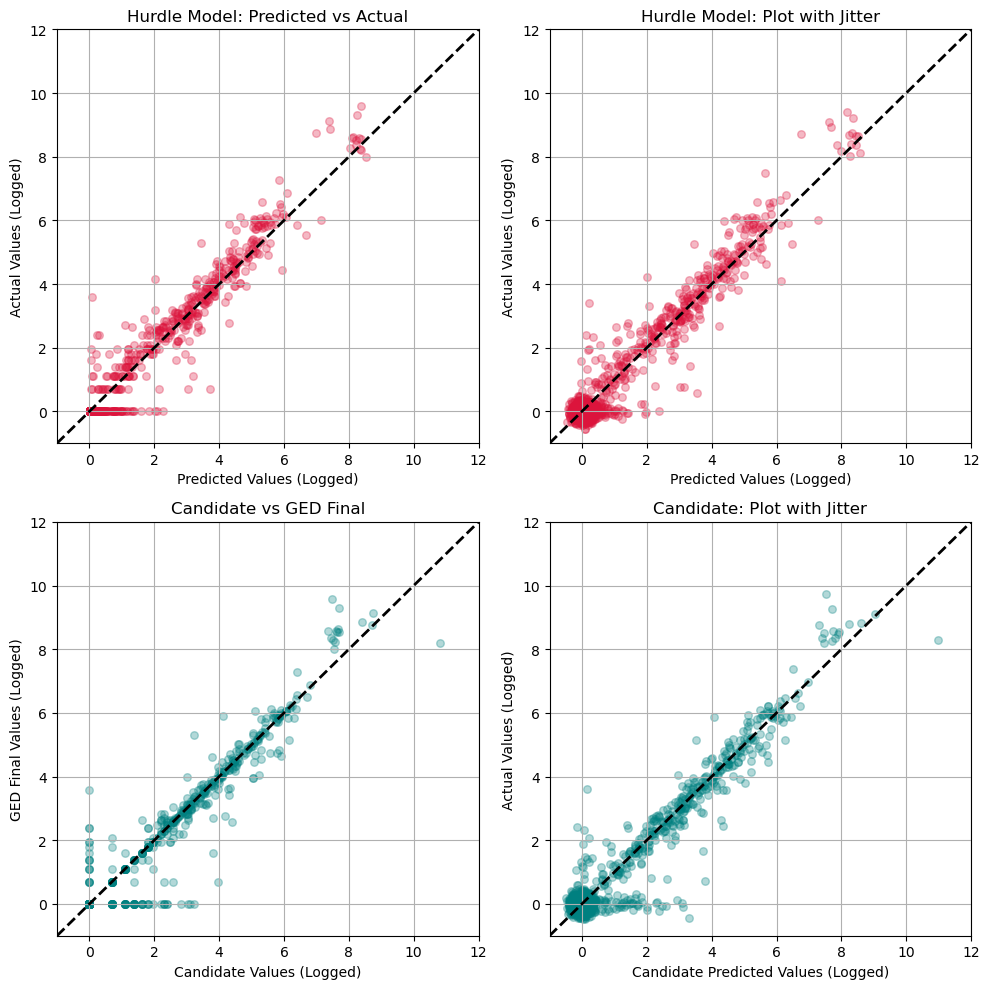

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score

# -------------------------------
# Training sets
# -------------------------------
X_train = train_long.drop(columns=['sb_final_best_ln'])
y_train = train_long['sb_final_best_ln']

# Test sets
X_test = test_long.drop(columns=['sb_final_best_ln'])
y_test = test_long['sb_final_best_ln']

# -------------------------------
# Create binary target (0 vs >0)
# -------------------------------
y_train_bin = (y_train > 0).astype(int)
y_test_bin = (y_test > 0).astype(int)

# -------------------------------
# XGBoost Classifier (Hurdle Stage 1)
# -------------------------------
xgb_classifier = xgb.XGBClassifier(
    eval_metric='logloss',
    learning_rate=0.03,
    max_depth=6,
    n_estimators=100,
    subsample=0.6,
    colsample_bytree=0.8,
    booster='dart',
    random_state=17
)

# Fit classifier
xgb_classifier.fit(X_train, y_train_bin)

# Predict classification probabilities
clf_probs = xgb_classifier.predict_proba(X_test)[:, 1]

# -------------------------------
# XGBoost Regressor (Hurdle Stage 2)
# -------------------------------
# Train only on rows where y > 0
X_train_pos = X_train[y_train > 0]
y_train_pos = y_train[y_train > 0]

xgb_regressor = xgb.XGBRegressor(
    eval_metric='rmse',
    learning_rate=0.06,
    max_depth=6,
    n_estimators=200,
    colsample_bytree=0.6,
    subsample=0.8,
    skip_drop=0.5,
    booster='dart',
    
    random_state=17
)

# Fit regressor
xgb_regressor.fit(X_train_pos, y_train_pos)

# Predict regression values on full test set
reg_preds = xgb_regressor.predict(X_test)

# -------------------------------
# Combine Hurdle Predictions
# -------------------------------
hurdle_preds = clf_probs * reg_preds

# -------------------------------
# Evaluate Model
# -------------------------------
mse = mean_squared_error(y_test, hurdle_preds)
rmse = np.sqrt(mse)

print("Hurdle Model MSE:", mse)
print("Hurdle Model RMSE:", rmse)
print("Classifier Accuracy (y > 0):", accuracy_score(y_test_bin, xgb_classifier.predict(X_test)))
print("")

# -------------------------------
# Compare with baseline (UCDP candidate best)
# -------------------------------
final_candidate = mean_squared_error(test_long['sb_final_best_ln'], test_long['sb_candidate_best_ln'])
print('MSE GED Final vs UCDP Candidate:', final_candidate)
print('RMSE GED Final vs UCDP Candidate:', np.sqrt(final_candidate))

# -------------------------------
# Plotting
# -------------------------------
jitter_amount = 0.15

# Jittered predictions for Hurdle
x_jittered_hurdle = hurdle_preds + np.random.normal(0, jitter_amount, size=len(hurdle_preds))
y_jittered_hurdle = y_test.values + np.random.normal(0, jitter_amount, size=len(y_test))

# Jittered predictions for Candidate Model
candidate_preds = test_long['sb_candidate_best_ln']
x_jittered_candidate = candidate_preds + np.random.normal(0, jitter_amount, size=len(candidate_preds))
y_jittered_candidate = y_test.values + np.random.normal(0, jitter_amount, size=len(y_test))

# Create 2x2 subplot layout
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

lims = [-1, 12]

# 1. Hurdle Predictions vs Actual
ax[0, 0].scatter(hurdle_preds, y_test, alpha=0.3, color='crimson', linewidth=1, s=30)
ax[0, 0].plot(lims, lims, 'k--', lw=2)
ax[0, 0].set_title('Hurdle Model: Predicted vs Actual')
ax[0, 0].set_xlabel('Predicted Values (Logged)')
ax[0, 0].set_ylabel('Actual Values (Logged)')
ax[0, 0].set_xlim(lims)
ax[0, 0].set_ylim(lims)
ax[0, 0].grid(True)

# 2. Hurdle Predictions vs Actual (with Jitter)
ax[0, 1].scatter(x_jittered_hurdle, y_jittered_hurdle, alpha=0.3, color='crimson', marker='o', linewidth=1, s=30)
ax[0, 1].plot(lims, lims, 'k--', lw=2)
ax[0, 1].set_title('Hurdle Model: Plot with Jitter')
ax[0, 1].set_xlabel('Predicted Values (Logged)')
ax[0, 1].set_ylabel('Actual Values (Logged)')
ax[0, 1].set_xlim(lims)
ax[0, 1].set_ylim(lims)
ax[0, 1].grid(True)

# 3. Candidate Predictions vs Actual
ax[1, 0].scatter(candidate_preds, y_test, alpha=0.3, color='teal', marker='o', linewidth=1, s=30)
ax[1, 0].plot(lims, lims, 'k--', lw=2)
ax[1, 0].set_title('Candidate vs GED Final')
ax[1, 0].set_xlabel('Candidate Values (Logged)')
ax[1, 0].set_ylabel('GED Final Values (Logged)')
ax[1, 0].set_xlim(lims)
ax[1, 0].set_ylim(lims)
ax[1, 0].grid(True)

# 4. Candidate Predictions vs Actual (with Jitter)
ax[1, 1].scatter(x_jittered_candidate, y_jittered_candidate, alpha=0.3, color='teal', marker='o', linewidth=1, s=30)
ax[1, 1].plot(lims, lims, 'k--', lw=2)
ax[1, 1].set_title('Candidate: Plot with Jitter')
ax[1, 1].set_xlabel('Candidate Predicted Values (Logged)')
ax[1, 1].set_ylabel('Actual Values (Logged)')
ax[1, 1].set_xlim(lims)
ax[1, 1].set_ylim(lims)
ax[1, 1].grid(True)

plt.tight_layout()
plt.show()


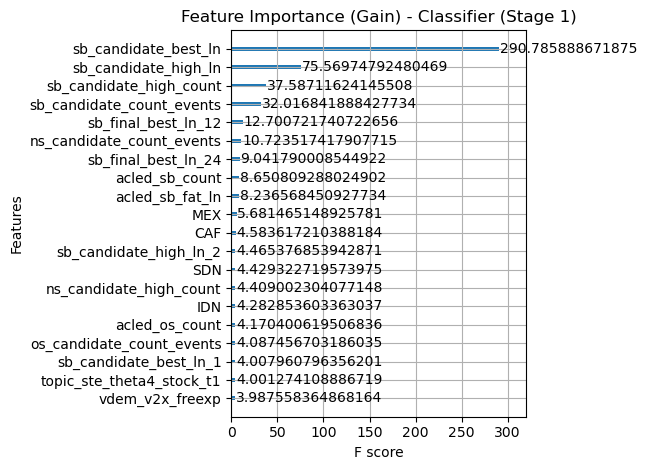

In [11]:
xgb_classifier.fit(X_train, y_train_bin)

xgb.plot_importance(xgb_classifier, importance_type='gain', max_num_features=20)
plt.title("Feature Importance (Gain) - Classifier (Stage 1)")
plt.tight_layout()
plt.show()


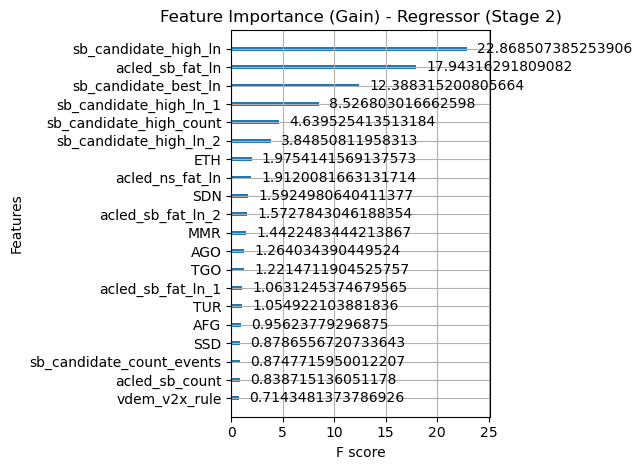

In [12]:
xgb_regressor.fit(X_train_pos, y_train_pos)

xgb.plot_importance(xgb_regressor, importance_type='gain', max_num_features=20)
plt.title("Feature Importance (Gain) - Regressor (Stage 2)")
plt.tight_layout()
plt.show()


### **Vizualizing these predictions**

In [13]:
df_results_hurdle = test_long.reset_index().copy()

# Keep only necessary columns
df_results_hurdle = df_results_hurdle[['c_id', 'month_id']]

# Add actual values and predictions
df_results_hurdle['Actual'] = y_test.values  # Ensure alignment
df_results_hurdle['Predicted'] = hurdle_preds  # Hurdle model predictions

# Add candidate model predictions
if 'sb_candidate_best_ln' in test_long.columns:
    df_results_hurdle['sb_candidate_best_ln'] = test_long.reset_index()['sb_candidate_best_ln']
else:
    df_results_hurdle['sb_candidate_best_ln'] = np.nan

# Add ACLED values if present
if 'acled_sb_fat_ln' in test_long.columns:
    df_results_hurdle['acled_sb_fat_ln'] = test_long.reset_index()['acled_sb_fat_ln']
else:
    df_results_hurdle['acled_sb_fat_ln'] = np.nan

# Ensure index is available for plotting
plot_df = df_results_hurdle.copy().reset_index(drop=False)

def plot_actual_vs_predicted(df, c_id):
    """
    Plots actual vs predicted values over month_id for a given c_id.

    :param df: DataFrame containing the data
    :param c_id: The c_id to filter the data
    """
    # Filter the DataFrame for the selected c_id
    filtered_df = df[df['c_id'] == c_id]

    # Set the index to month_id for plotting
    filtered_df.set_index('month_id', inplace=True)

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_df['Actual'], color='black', label='Actuals')
    plt.plot(filtered_df['Predicted'], color='#FF6700', linestyle='dashed', label='Hurdle Predictions')
    plt.plot(filtered_df['sb_candidate_best_ln'], color='#800080', linestyle='dashed', label='Candidate')
    plt.plot(filtered_df['acled_sb_fat_ln'], color='#008000', alpha=0.3, label='ACLED')

    # Adding labels and title
    plt.xlabel('Month ID')
    plt.ylabel('Fatalities (Logged)')
    plt.title(f'Actual vs Predicted Fatalities for c_id: {c_id}')
    plt.legend()

    # Show the plot
    plt.show()


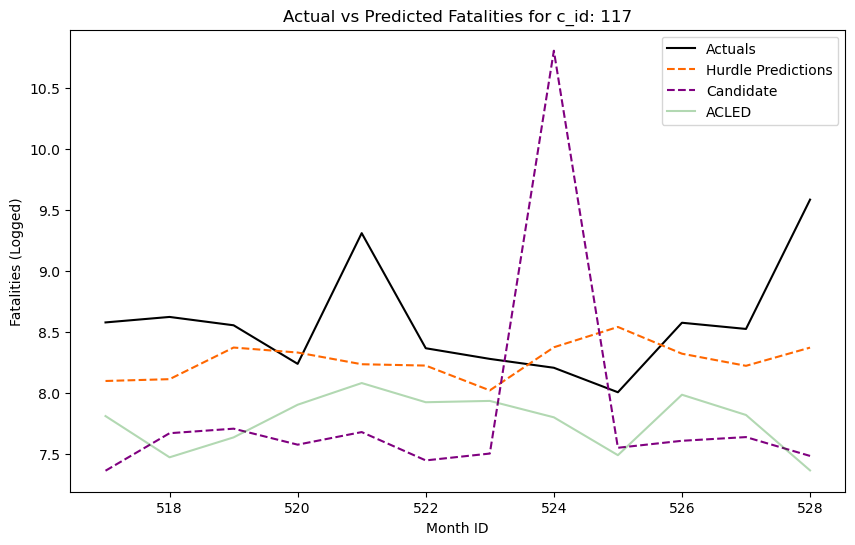

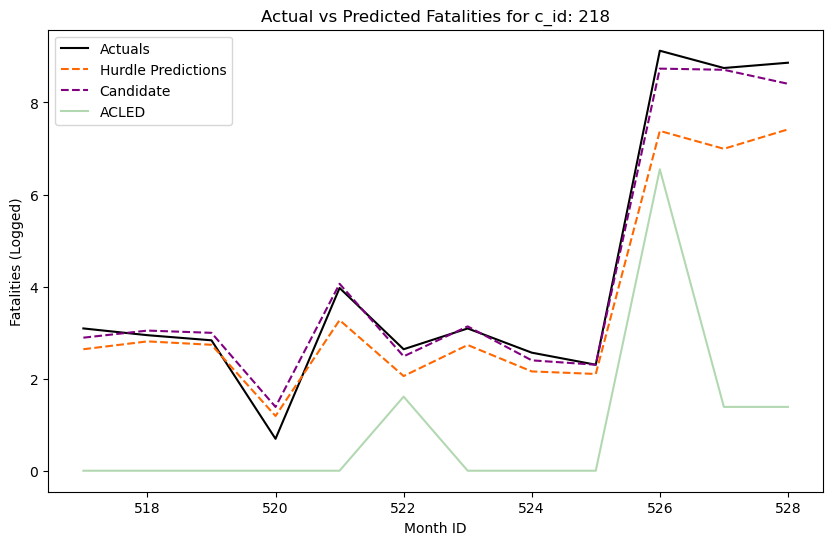

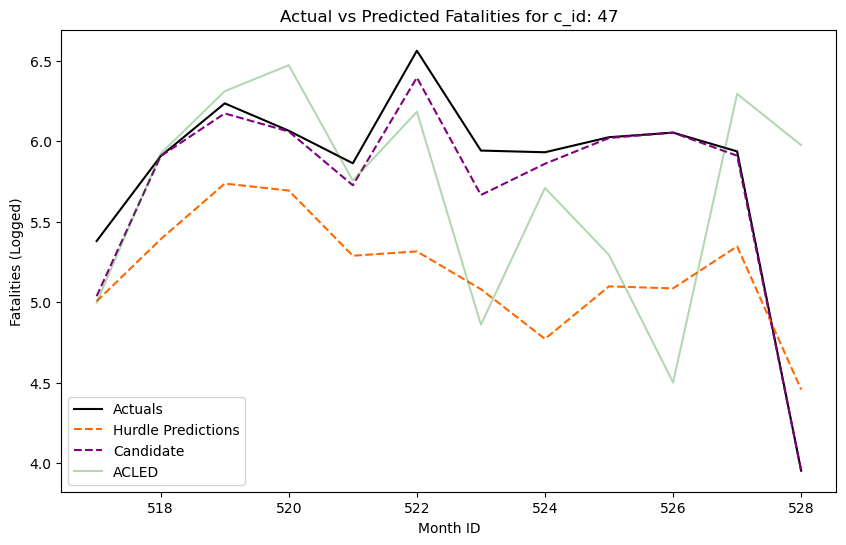

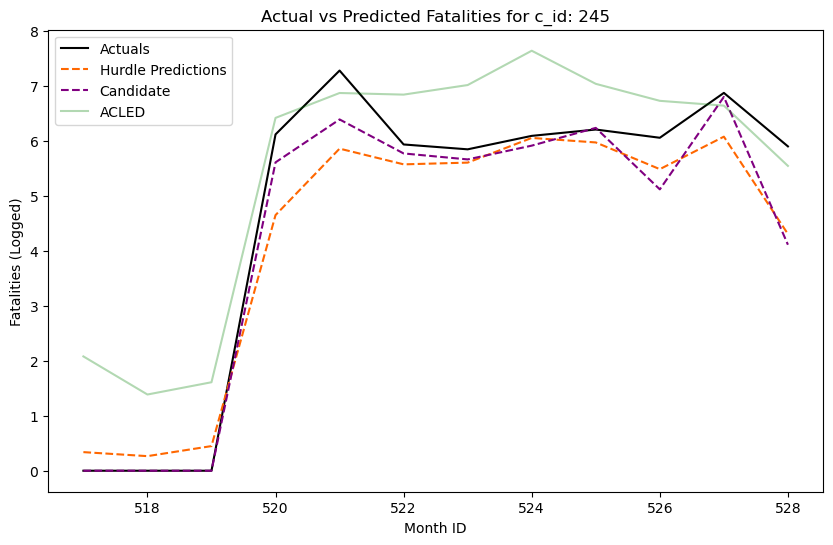

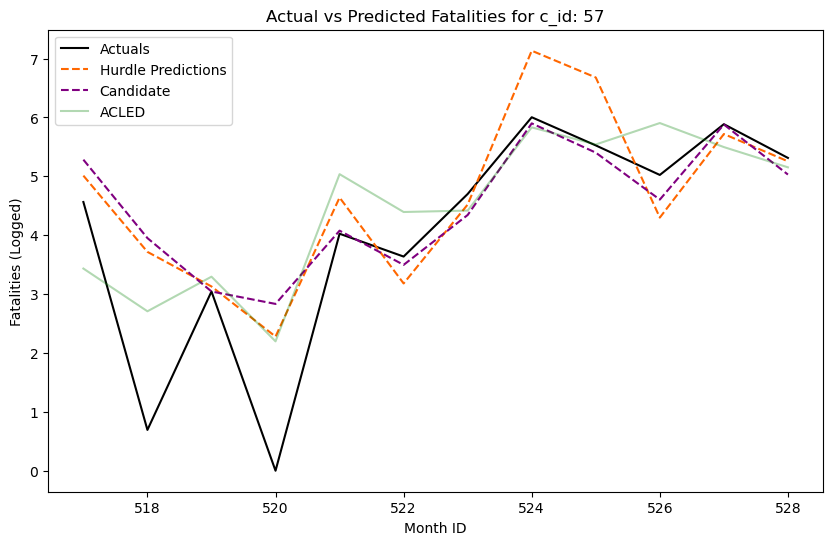

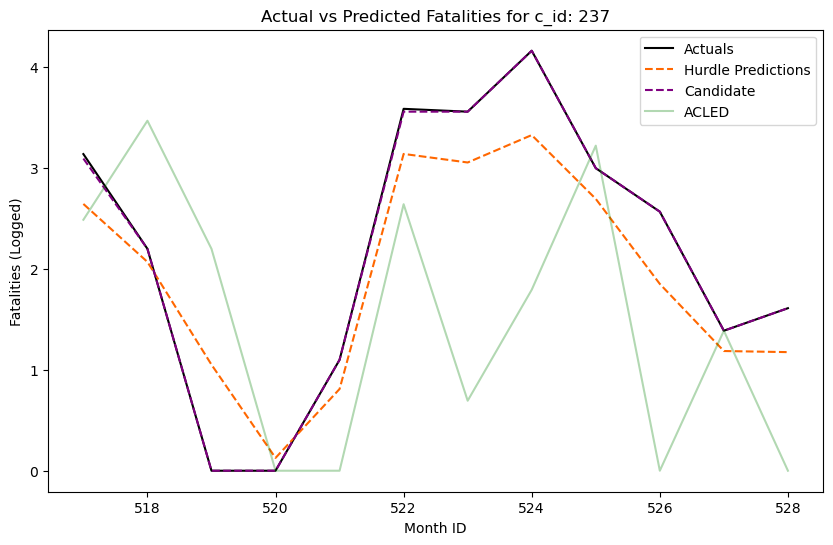

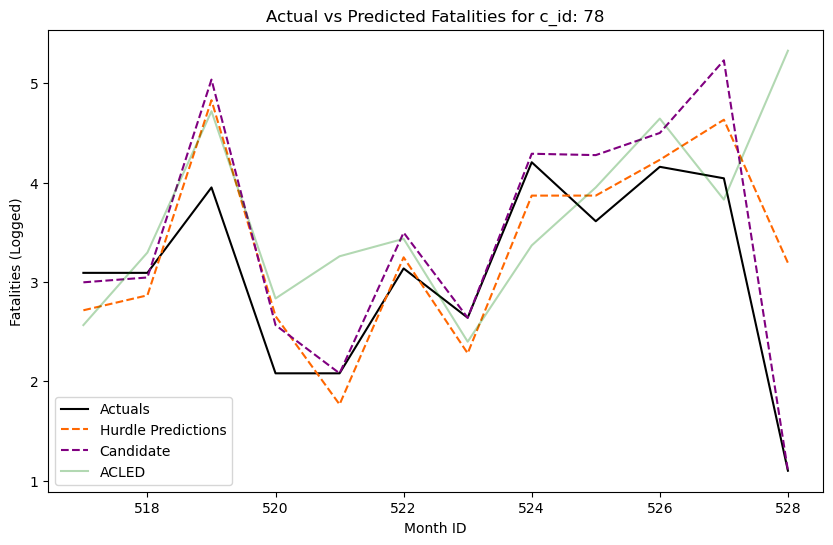

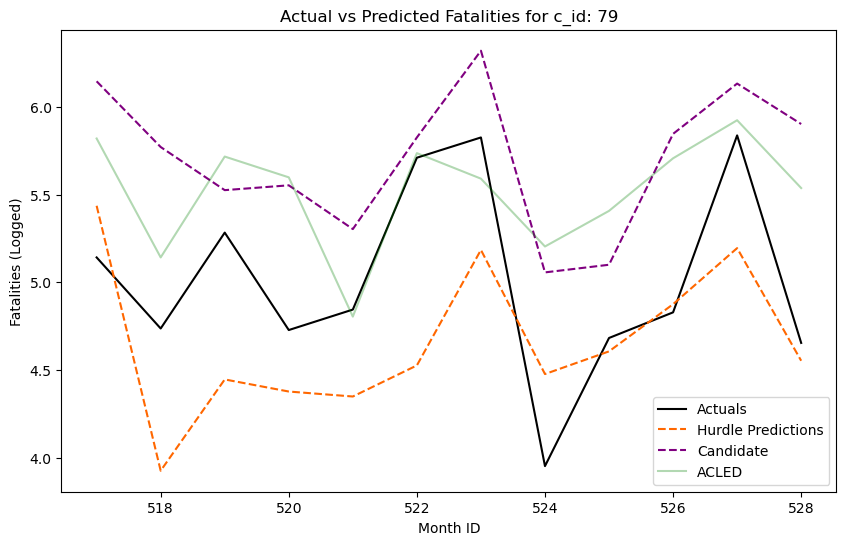

In [48]:
plot_actual_vs_predicted(plot_df, 117) # ukraine
plot_actual_vs_predicted(plot_df, 218) # Isreal
plot_actual_vs_predicted(plot_df, 47) # Burkina Faso
plot_actual_vs_predicted(plot_df, 245) # Sudan
plot_actual_vs_predicted(plot_df, 57) # Ethiopia
plot_actual_vs_predicted(plot_df, 237) #Kenya
plot_actual_vs_predicted(plot_df, 78) # Niger
plot_actual_vs_predicted(plot_df, 79) # 


# 4.1: Unceratinty Hurdle Model

This model adds uncertainty to the predictions. The model provides confidence intervals for each country-month.

In [15]:
from sklearn.utils import resample

def bootstrap_hurdle_predictions(classifier_model, regressor_model, 
                                  X_train, y_train, X_test, 
                                  n_models=800, ci_percentile=(2.5, 97.5)):
    """
    Bootstrap Hurdle Model to get uncertainty estimates.
    
    Parameters:
    - classifier_model: XGBClassifier
    - regressor_model: XGBRegressor
    - X_train: full training features
    - y_train: full training target
    - X_test: test features
    - n_models: number of bootstrapped models
    - ci_percentile: tuple for CI bounds (e.g., (10, 90))
    
    Returns:
    - mean_preds: Mean of bootstrap hurdle predictions
    - lower_bound: Lower CI bound
    - upper_bound: Upper CI bound
    - all_preds: All bootstrap hurdle predictions (n_models × n_obs)
    """
    n_obs = X_test.shape[0]
    all_preds = np.zeros((n_models, n_obs))

    for i in range(n_models):
        # Bootstrap sampling
        X_resampled, y_resampled = resample(X_train, y_train, random_state=i)

        # Binary labels
        y_resampled_bin = (y_resampled > 0).astype(int)

        # Stage 1: Fit classifier
        clf = xgb.XGBClassifier(**classifier_model.get_xgb_params())
        clf.fit(X_resampled, y_resampled_bin)
        clf_probs = clf.predict_proba(X_test)[:, 1]

        # Stage 2: Fit regressor on positive samples
        mask_pos = y_resampled > 0
        X_resampled_pos = X_resampled[mask_pos]
        y_resampled_pos = y_resampled[mask_pos]

        reg = xgb.XGBRegressor(**regressor_model.get_xgb_params())
        reg.fit(X_resampled_pos, y_resampled_pos)
        reg_preds = reg.predict(X_test)

        # Combine
        all_preds[i] = clf_probs * reg_preds

    # Aggregate
    mean_preds = all_preds.mean(axis=0)
    lower_bound = np.percentile(all_preds, ci_percentile[0], axis=0)
    upper_bound = np.percentile(all_preds, ci_percentile[1], axis=0)

    return mean_preds, lower_bound, upper_bound, all_preds


In [16]:
# Get bootstrap uncertainty estimates
mean_preds, lower_ci, upper_ci, all_preds = bootstrap_hurdle_predictions(
    classifier_model=xgb_classifier,
    regressor_model=xgb_regressor,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    n_models=800,  
    ci_percentile=(2.5, 97.5)
)

In [17]:
# Evaluate
mse_uncertain = mean_squared_error(y_test, mean_preds)
print(f"Hurdle Model with Uncertainty MSE: {mse_uncertain:.4f}")
rmse = np.sqrt(mean_squared_error(y_test, mean_preds))
print(f"Hurdle Model with Uncertainty RMSE: {rmse:.4f}")

final_candidate = mean_squared_error(test_long['sb_final_best_ln'], test_long['sb_candidate_best_ln'])
print('MSE GED Final vs UCDP Candidate:', final_candidate)
print('RMSE GED Final vs UCDP Candidate:', np.sqrt(final_candidate))

Hurdle Model with Uncertainty MSE: 0.0932
Hurdle Model with Uncertainty RMSE: 0.3053
MSE GED Final vs UCDP Candidate: 0.11784603486537017
RMSE GED Final vs UCDP Candidate: 0.343287102678458


### **Vizualizing this model**

In [20]:
# Extract index values
c_ids = test_long.index.get_level_values("c_id")
month_ids = test_long.index.get_level_values("month_id")
sb_candidates = test_long['sb_candidate_best_ln'].values  
acled = test_long['acled_sb_fat_ln'].values

# Construct the result DataFrame for plotting
results_df = pd.DataFrame({
    'month_id': month_ids,
    'c_id': c_ids,
    'actual': y_test.values,
    'pred': mean_preds,
    'lower': lower_ci,
    'upper': upper_ci,
    'sb_candidate_best_ln': sb_candidates,
    'acled_sb_fat_ln': acled
})

def plot_hurdle_predictions_by_cid(results_df, c_id_to_plot):
    """
    Plots actual, predicted, and CI for a specific c_id from hurdle model results.
    
    Parameters:
    - results_df: DataFrame with 'c_id', 'month_id', 'actual', 'pred', 'lower', 'upper'
    - c_id_to_plot: the c_id to visualize
    """
    subset = results_df[results_df['c_id'] == c_id_to_plot].copy()
    subset = subset.sort_values('month_id').reset_index(drop=True)

    plt.figure(figsize=(12, 3))
    plt.plot(subset.index, subset['actual'], 'o--', label='Actual Values', color='black', alpha=0.7)
    plt.plot(subset.index, subset['pred'], 'x-', label='Hurdle Prediction', color='#FF6700')
    plt.fill_between(subset.index, subset['lower'], subset['upper'],
                     color='#FF6700', alpha=0.2, label='95% Prediction Interval')
    
    # Add candidate variable
    if 'sb_candidate_best_ln' in subset.columns:
        plt.plot(subset.index, subset['sb_candidate_best_ln'], 's--', 
                 label='SB Candidate (log)', color='blue', alpha=0.1)
        
    # Add candidate variable
    if 'acled_sb_fat_ln' in subset.columns:
        plt.plot(subset.index, subset['acled_sb_fat_ln'], 's--', 
                 label='ACLED (log)', color='green', alpha=0.1)

    plt.title(f'Hurdle Model: Actual, Predicted, and CI for c_id: {c_id_to_plot}')
    plt.xlabel('Time Index (sorted by month_id)')
    plt.ylabel('Logged Fatalities')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


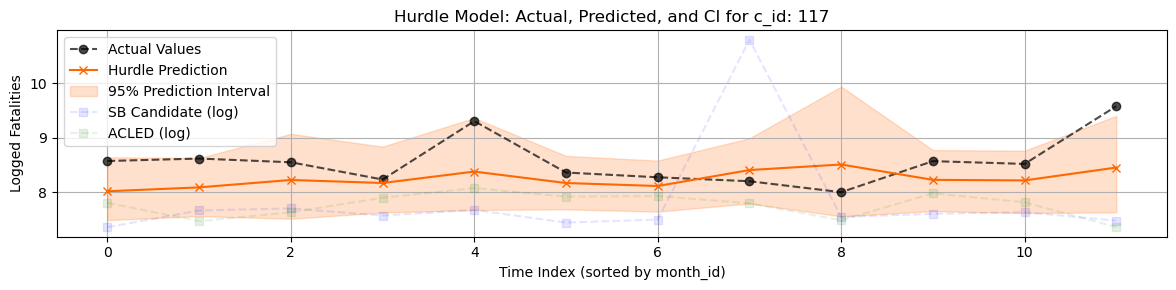

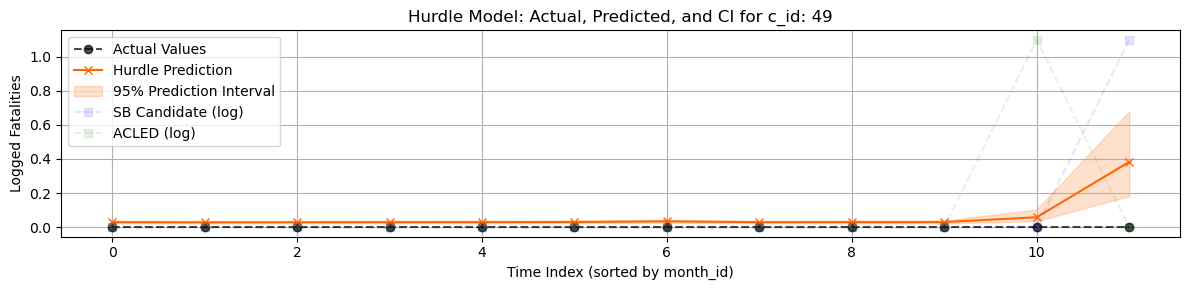

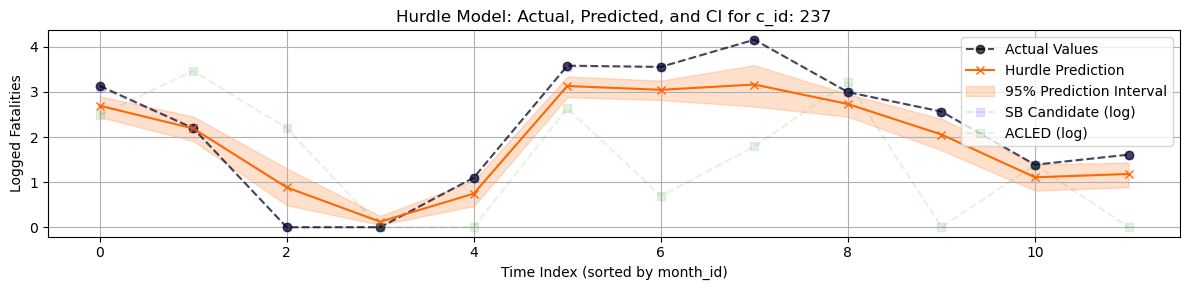

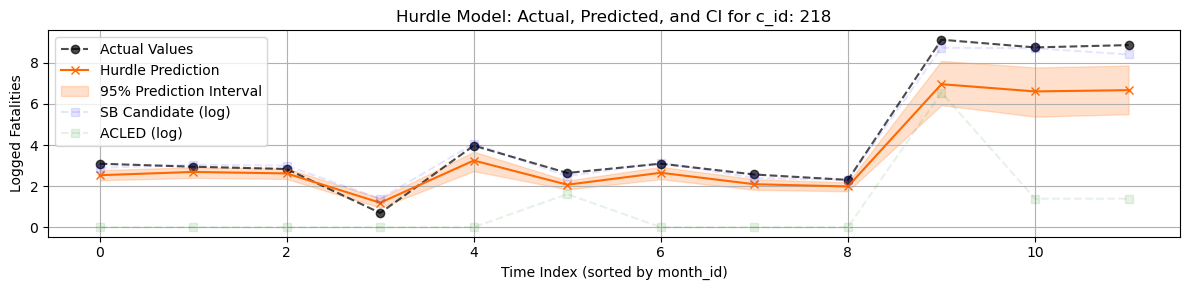

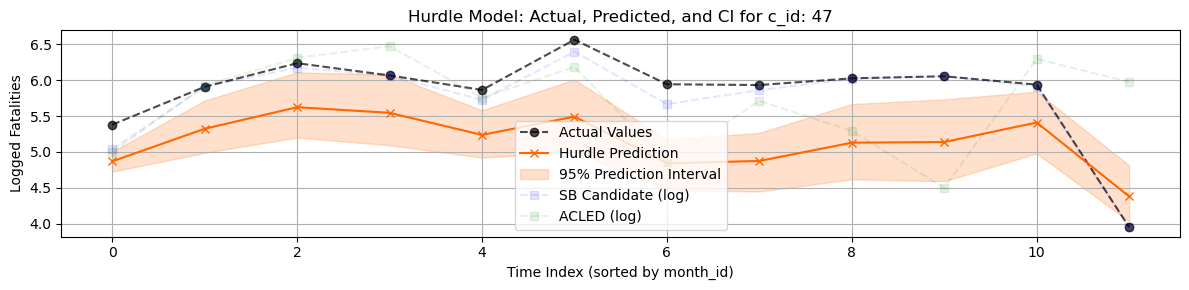

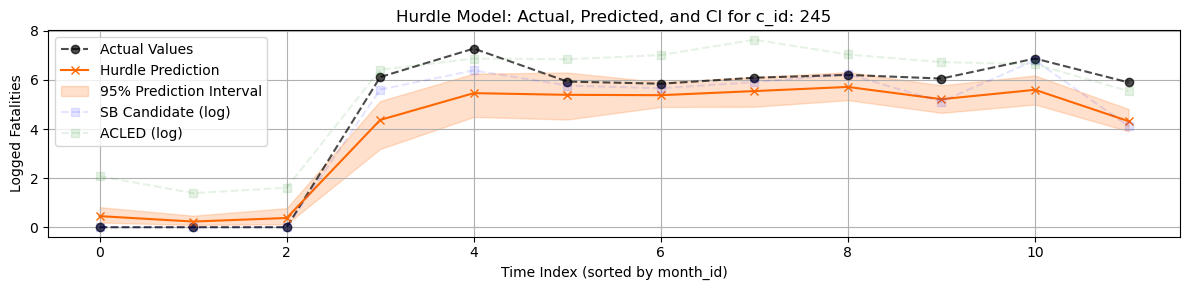

In [37]:
plot_hurdle_predictions_by_cid(results_df, c_id_to_plot=117)
plot_hurdle_predictions_by_cid(results_df, c_id_to_plot=49)
plot_hurdle_predictions_by_cid(results_df, c_id_to_plot=237)
plot_hurdle_predictions_by_cid(results_df, c_id_to_plot=218)
plot_hurdle_predictions_by_cid(results_df, c_id_to_plot=47)
plot_hurdle_predictions_by_cid(results_df, c_id_to_plot=245)

# 5.0: Stacking

In [161]:
# Define predictors (the predictions/signals from each base model)
X = results_df[['pred', 'sb_candidate_best_ln', 'acled_sb_fat_ln', 'lower', 'upper']].values

# Actual values
y = results_df['actual'].values

# Placeholder for meta-model predictions
meta_preds_oof = np.zeros(len(results_df))

tscv = TimeSeriesSplit(n_splits=4)

for train_idx, val_idx in tscv.split(X):
    X_train, y_train = X[train_idx], y[train_idx]
    X_val = X[val_idx]

    # Meta-model learns how to weight/adjust the base predictions
    meta_model = XGBRegressor(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        objective='reg:squarederror',
        random_state=42
    )
    
    meta_model.fit(X_train, y_train)
    meta_preds_oof[val_idx] = meta_model.predict(X_val)

    results_df['stacked'] = meta_preds_oof

rmse_base = mean_squared_error(results_df['actual'], results_df['pred'], squared=False)
rmse_meta = mean_squared_error(results_df['actual'], results_df['stacked'], squared=False)

print(f"Base Model RMSE:       {rmse_base:.3f}")
print(f"Stacked Model RMSE: {rmse_meta:.3f}")



Base Model RMSE:       0.305
Stacked Model RMSE: 0.722


In [167]:
def plot_stack_cid(results_df, c_id_to_plot):
    """
    Plots actual, predicted, and CI for a specific c_id from hurdle model results.
    
    Parameters:
    - results_df: DataFrame with 'c_id', 'month_id', 'actual', 'pred', 'lower', 'upper'
    - c_id_to_plot: the c_id to visualize
    """
    subset = results_df[results_df['c_id'] == c_id_to_plot].copy()
    subset = subset.sort_values('month_id').reset_index(drop=True)

    plt.figure(figsize=(12, 3))
    plt.plot(subset.index, subset['actual'], 'o--', label='Actual Values', color='black', alpha=0.7)
    plt.plot(subset.index, subset['pred'], 'x-', label='Hurdle Prediction', color='#FF6700')
    plt.fill_between(subset.index, subset['lower'], subset['upper'],
                     color='#FF6700', alpha=0.2, label='95% Prediction Interval')
    
    # Add candidate variable
    if 'sb_candidate_best_ln' in subset.columns:
        plt.plot(subset.index, subset['sb_candidate_best_ln'], 's--', 
                 label='SB Candidate', color='blue', alpha=0.1)
        
    # Add candidate variable
    #if 'acled_sb_fat_ln' in subset.columns:
    #    plt.plot(subset.index, subset['acled_sb_fat_ln'], 's--', 
    #             label='ACLED', color='green', alpha=0.1)
        
    # Add candidate variable
    if 'stacked' in subset.columns:
        plt.plot(subset.index, subset['stacked'], 's-', 
                 label='stacked', color='red', alpha=0.5)

    plt.title(f'Hurdle Model: Actual, Predicted, and CI for c_id: {c_id_to_plot}')
    plt.xlabel('Time Index (sorted by month_id)')
    plt.ylabel('Logged Fatalities')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [166]:
results_df

,month_id,c_id,actual,pred,lower,upper,sb_candidate_best_ln,acled_sb_fat_ln,meta_pred,meta_pred_xgb,stacked,stacked_filled
0,517,1,0.000000,0.027027,0.020757,0.034874,0.000000,0.000000,0.000000,0.000000,0.027027,0.000000
1,517,2,0.000000,0.036677,0.025925,0.048867,0.000000,0.000000,0.000000,0.000000,0.036677,0.000000
2,517,3,0.000000,0.042771,0.028136,0.060712,0.000000,0.000000,0.000000,0.000000,0.042771,0.000000
3,517,4,0.000000,0.076082,0.045377,0.127707,0.000000,1.609438,0.000000,0.000000,0.076082,0.000000
4,517,5,0.000000,0.037833,0.026425,0.050440,0.000000,0.000000,0.000000,0.000000,0.037833,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
2287,528,242,0.000000,0.097498,0.033478,0.233150,0.000000,0.000000,0.041968,0.047630,0.040831,0.040831
2288,528,243,1.609438,0.055796,0.034119,0.093594,0.000000,1.609438,0.010090,0.075909,0.010580,0.010580
2289,528,244,0.000000,0.031871,0.023821,0.042266,0.000000,0.000000,-0.008198,0.006417,0.001424,0.001424
2290,528,245,5.899897,4.320979,3.910359,4.815631,4.110874,5.545177,4.354103,4.000535,4.062933,4.062933


### **Fill the hurdle predictions in for the early stacked versions**

In [171]:
results_df.loc[results_df['month_id'].isin([517, 518]), 'stacked'] = \
    results_df.loc[results_df['month_id'].isin([517, 518]), 'pred']

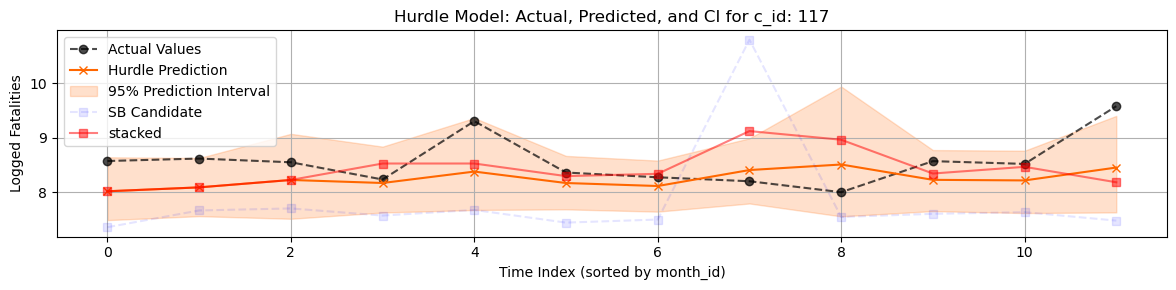

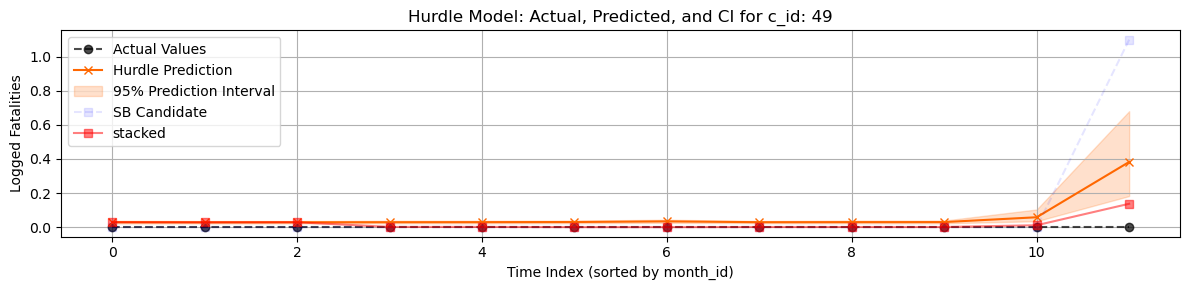

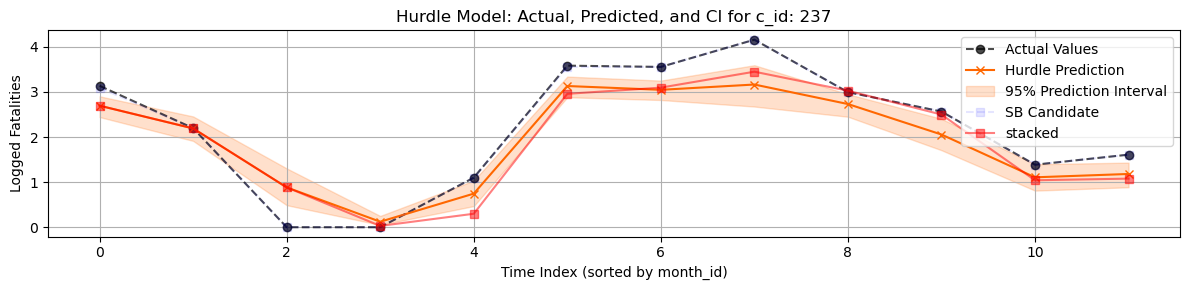

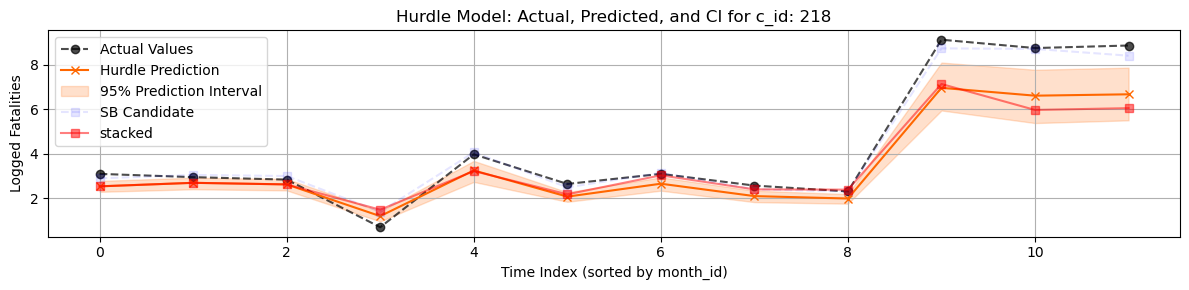

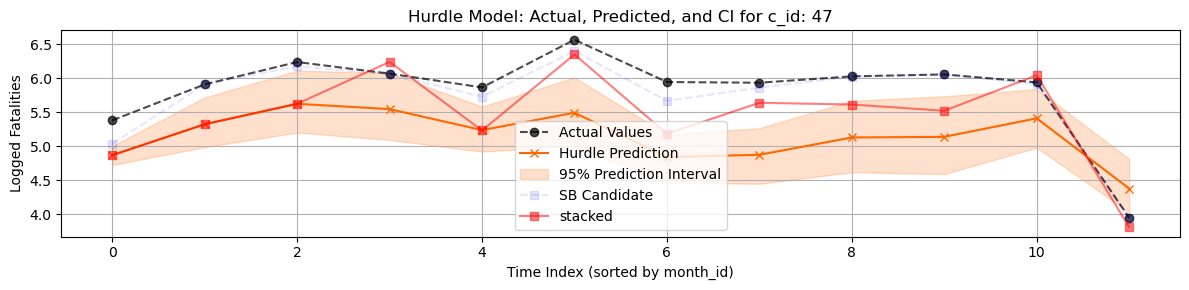

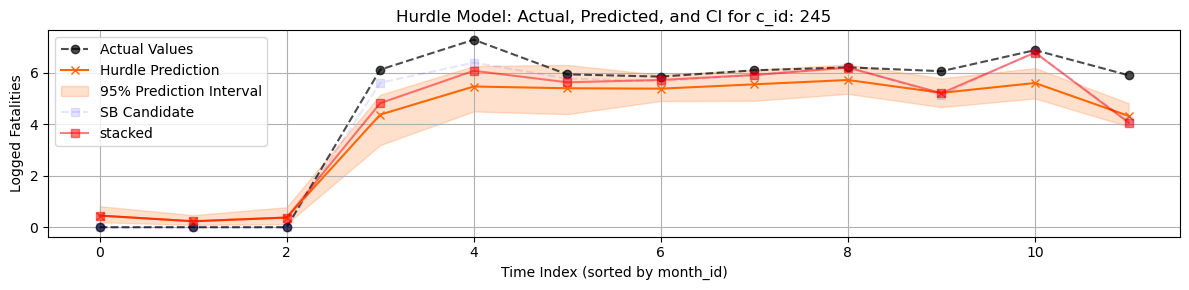

In [172]:
plot_stack_cid(results_df, c_id_to_plot=117)
plot_stack_cid(results_df, c_id_to_plot=49)
plot_stack_cid(results_df, c_id_to_plot=237)
plot_stack_cid(results_df, c_id_to_plot=218)
plot_stack_cid(results_df, c_id_to_plot=47)
plot_stack_cid(results_df, c_id_to_plot=245)

### **Seeing feature importance for the Stacked model**

As shown the most important features in the stacked model are the hurdle model predictions and the and the lower bound of the uncertain hurdel model.

In [140]:
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# Define predictors and target
X_full = results_df[['pred', 'sb_candidate_best_ln', 'acled_sb_fat_ln', 'lower', 'upper']]
y_full = results_df['actual']

# Train the final meta-model on all data
meta_model_full = XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    objective='reg:squarederror',
    random_state=42
)

meta_model_full.fit(X_full, y_full)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

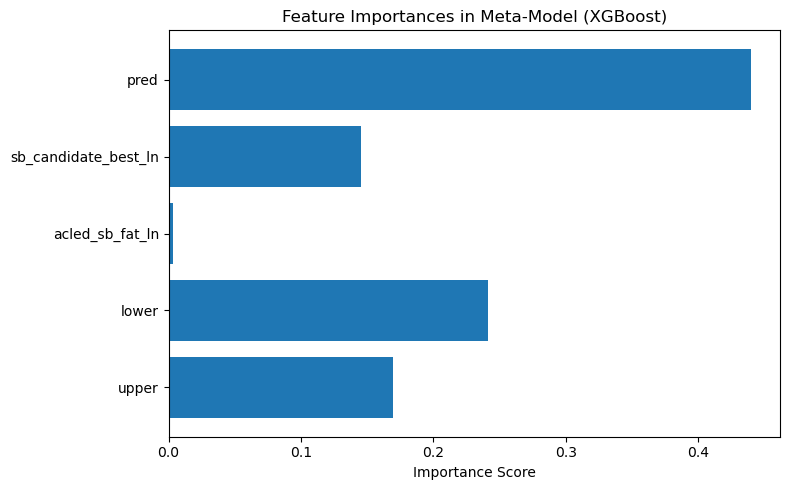

In [141]:
# Plot importance
plt.figure(figsize=(8, 5))
xgb_importances = meta_model_full.feature_importances_
features = X_full.columns

plt.barh(features, xgb_importances)
plt.title("Feature Importances in Meta-Model (XGBoost)")
plt.xlabel("Importance Score")
plt.gca().invert_yaxis()  # Highest at the top
plt.tight_layout()
plt.show()
